# Persistencia ZigZag

In [1]:
import numpy as np
import pandas as pd
import itertools as it
import dionysus as d
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import os
import networkx as nx

#### descargamos datos de una simulación

In [2]:
path = os.getcwd()

num_simulacion = '000003'
# Define la ruta completa de la carpeta donde estan los archivos .dat de la simulacion
carpeta = os.path.join(path,'Am66', f"20170505_{num_simulacion}",'tracorrTh35')

# Lista de todos los archivos .dat
dat_files = [file for file in os.listdir(carpeta) if file.endswith('.dat')]

lista_df = []
for file in dat_files:
        
    # Carga el archivo como DataFrame
    df = pd.read_csv(
            os.path.join(carpeta, file), 
            sep=r'\s+',  # Delimitador de espacios o múltiples espacios
            names=['Frame', 'X', 'Y'],  # Nombres de las columnas
            header=None  # Si no hay fila de encabezado en el archivo
        )
    # Añadimos la columna para identificar el individuo
    df['Id'] = file[-7:-4]
    #df ['Tiempo'] = (df['Frame']/25)  #si queremos tiempo seg
    

    # Guardamos en una lista
    lista_df.append(df)

#creamos el dataframe con todos los datos
dataframe = pd.concat(lista_df, ignore_index=True)
df = dataframe.groupby(['Frame', 'Id'])[['X', 'Y']].mean().reset_index()
df

,Frame,Id,X,Y
0,375.0,001,1.655653,0.180915
1,375.0,002,0.709909,0.213053
2,375.0,003,1.225999,0.239687
3,375.0,004,-0.223997,0.259243
4,375.0,005,-1.067060,0.262598
...,...,...,...,...
90868,1990.0,185,-0.079632,0.306310
90869,1991.0,185,-0.077010,0.261731
90870,1992.0,185,-0.073588,0.218626
90871,1993.0,185,-0.067083,0.173074


### juntamos los datos en un dataframe

#### definimos los parametros

In [4]:
#cogemos una muestra reducida cada 'intervalo_t' frames.
num_tiempos = 3
intervalo_t = 5

#empezamos a partir del frame 500 (ejemplo), manualente se poueden descargar distintos intervalos dentro de una misma simulacion.
t_min = int(df['Frame'][0] + 500)  
t_max = t_min + num_tiempos*intervalo_t  
dist_cuadrado = 2 #distancia de la muestra 

t = np.arange(t_min, t_max, intervalo_t)
t

array([875, 880, 885])

In [5]:
df_t = df[df['Frame'].isin(t)]

#Filtramos los individuos que estan dentro de este cuadrado durante este tiempo
df_t = df_t.copy()
df_t['XY'] = 'No'
df_t.loc[(abs(df_t['X']) < dist_cuadrado/2 ) & (df_t['Y'] < dist_cuadrado),'XY'] = 'Si'
df_res = df_t[df_t['XY'] == 'Si']
df_res = df_res.copy()
df_res.drop('XY', axis=1, inplace=True)

df_res

,Frame,Id,X,Y
38132,875.0,016,-0.385987,0.558439
38133,875.0,023,-0.820811,0.536330
38137,875.0,033,0.498402,0.558066
38139,875.0,035,-0.582473,0.862947
38141,875.0,040,0.862579,1.094554
...,...,...,...,...
38929,885.0,078,0.628878,1.856597
38930,885.0,079,-0.058980,1.438519
38932,885.0,081,0.311261,1.702007
38934,885.0,083,-0.484247,1.965501


In [6]:
#mostramos los individuos
individuos = df_res['Id'].unique()
n = len(individuos)

print(individuos)

['016' '023' '033' '035' '040' '044' '050' '051' '056' '057' '059' '061'
 '062' '063' '065' '066' '071' '074' '078' '079' '081' '084' '083']


# Inicializamos tabla lógica

### definimos las dimensiones y los tiempos

In [7]:
#definimos en dim1 los individuos
indices = list(individuos)
dim2 = [list(comb) for comb in it.permutations(indices, 2)]  #para que sea una lista de listas
dim3 = [list(comb) for comb in it.permutations(indices, 3)]

#creamos el listado de posibles simplices y los dataframes
s = indices + dim2 + dim3
s

['016',
 '023',
 '033',
 '035',
 '040',
 '044',
 '050',
 '051',
 '056',
 '057',
 '059',
 '061',
 '062',
 '063',
 '065',
 '066',
 '071',
 '074',
 '078',
 '079',
 '081',
 '084',
 '083',
 ['016', '023'],
 ['016', '033'],
 ['016', '035'],
 ['016', '040'],
 ['016', '044'],
 ['016', '050'],
 ['016', '051'],
 ['016', '056'],
 ['016', '057'],
 ['016', '059'],
 ['016', '061'],
 ['016', '062'],
 ['016', '063'],
 ['016', '065'],
 ['016', '066'],
 ['016', '071'],
 ['016', '074'],
 ['016', '078'],
 ['016', '079'],
 ['016', '081'],
 ['016', '084'],
 ['016', '083'],
 ['023', '016'],
 ['023', '033'],
 ['023', '035'],
 ['023', '040'],
 ['023', '044'],
 ['023', '050'],
 ['023', '051'],
 ['023', '056'],
 ['023', '057'],
 ['023', '059'],
 ['023', '061'],
 ['023', '062'],
 ['023', '063'],
 ['023', '065'],
 ['023', '066'],
 ['023', '071'],
 ['023', '074'],
 ['023', '078'],
 ['023', '079'],
 ['023', '081'],
 ['023', '084'],
 ['023', '083'],
 ['033', '016'],
 ['033', '023'],
 ['033', '035'],
 ['033', '040'],


### cargamos las coordenadas de nuestros datos y hacemos un diccionario para poder traducirlas a los indices

In [8]:
lista_dic_p = np.array([])
#guardamos las coordenadas de cada tiempo para hacer VR
lista_t = []
for tiempo in t:
    #filtramos el df para cada tiempo
    df_tiempo = df_res[df_res['Frame'] == tiempo]
    n = len(df_tiempo)

    #almacenamos las coordenadas junto con su id para cada tiempo en una lista
    dic_p = {}
    puntos_t = []
    for i in range(n):
        X = float(df_tiempo.iloc[i]['X'])
        Y = float(df_tiempo.iloc[i]['Y'])
        Id = df_tiempo.iloc[i]['Id']

        dic_p[Id] = [X,Y]
        puntos_t.append([X,Y])
    lista_t.append(puntos_t)
    lista_dic_p = np.append(lista_dic_p, dic_p)

for i,dic in enumerate(lista_dic_p):
   print('Frame',t[i])
   print(dic)

Frame 875
{'016': [-0.38598693, 0.55843913], '023': [-0.82081057, 0.53632972], '033': [0.49840167, 0.55806609], '035': [-0.58247298, 0.86294699], '040': [0.8625793, 1.0945537], '044': [-0.93397276, 1.3100004], '050': [-0.99086116, 1.6006439], '051': [-0.77666155, 1.0789975], '056': [0.56841383, 0.84251341], '057': [-0.36130078, 1.3741726], '059': [0.71252914, 1.4272586], '061': [-0.077228858, 0.52245036], '062': [0.17127081, 0.85462155], '063': [0.020111758, 0.20838682], '065': [-0.47851723, 1.7006838], '066': [0.95036143, 1.9006076], '071': [-0.31821388, 0.24963874], '074': [0.32757019, 1.2965729], '078': [0.57600392, 1.8561454], '079': [-0.043683743, 1.5161294], '081': [0.34443211, 1.683347], '084': [-0.18904471, 0.96176018]}
Frame 880
{'016': [-0.39284539, 0.52134147], '023': [-0.79242621, 0.54148819], '033': [0.46790472, 0.51950398], '035': [-0.56886409, 0.83351345], '040': [0.81129906, 1.1014692], '044': [-0.91101042, 1.3236137], '050': [-0.98453233, 1.6024326], '051': [-0.7183307

# matriz de distancias

In [9]:
n =len(individuos)
cont = 0

for dic in lista_dic_p:
    n = len(dic)
    m_distancias = np.zeros((n,n))
    for i, p1 in enumerate(dic.values()):
        for j, p2 in enumerate(dic.values()):
            m_distancias[i,j] = np.sqrt(np.sum((np.array(p2) - np.array(p1)) ** 2))

    df_distancias = pd.DataFrame(m_distancias, index=dic.keys(), columns=dic.keys())

    print('Tiempo',t[cont])
    cont += 1
    
    #mostrar dataframe
    display(df_distancias)


Tiempo 875


,016,023,033,035,040,044,050,051,056,057,...,062,063,065,066,071,074,078,079,081,084
016,0.000000,0.435385,0.884389,0.362397,1.358800,0.930125,1.205016,0.650852,0.995781,0.816107,...,0.631079,0.536146,1.145986,1.894002,0.316150,1.026648,1.615385,1.017026,1.341242,0.448836
023,0.435385,0.000000,1.319391,0.404331,1.773532,0.781903,1.077813,0.544461,1.422566,0.955578,...,1.041890,0.902606,1.213625,2.235689,0.578615,1.377225,1.921719,1.250573,1.635065,0.761656
033,0.884389,1.319391,0.000000,1.123050,0.648417,1.617746,1.817931,1.377373,0.292937,1.185377,...,0.441542,0.592484,1.503312,1.416575,0.872919,0.758008,1.300397,1.100791,1.135766,0.797215
035,0.362397,0.404331,1.123050,0.000000,1.463495,0.568690,0.843195,0.290494,1.151068,0.557018,...,0.753790,0.889695,0.844162,1.851032,0.667817,1.008072,1.525946,0.846724,1.237824,0.405647
040,1.358800,1.773532,0.648417,1.463495,0.000000,1.809424,1.921294,1.639315,0.387373,1.255416,...,0.731761,1.222720,1.471711,0.810820,1.451948,0.571880,0.813724,0.999519,0.784318,1.059975
044,0.930125,0.781903,1.617746,0.568690,1.809424,0.000000,0.296159,0.279480,1.573439,0.576256,...,1.195380,1.457337,0.600061,1.974723,1.226183,1.261614,1.605710,0.913840,1.331806,0.822307
050,1.205016,1.077813,1.817931,0.843195,1.921294,0.296159,0.000000,0.563912,1.733811,0.669056,...,1.380978,1.720595,0.522019,1.964262,1.509195,1.353041,1.587560,0.950940,1.337852,1.025223
051,0.650852,0.544461,1.377373,0.290494,1.639315,0.279480,0.563912,0.000000,1.365706,0.509561,...,0.974125,1.180174,0.689481,1.912499,0.947634,1.125463,1.560020,0.853429,1.273613,0.599198
056,0.995781,1.422566,0.292937,1.151068,0.387373,1.573439,1.733811,1.365706,0.000000,1.070995,...,0.397328,0.838303,1.353706,1.124921,1.066588,0.513980,1.013660,0.910177,0.870155,0.766788
057,0.816107,0.955578,1.185377,0.557018,1.255416,0.576256,0.669056,0.509561,1.070995,0.000000,...,0.744020,1.226594,0.346914,1.413362,1.125359,0.693228,1.053963,0.347897,0.770485,0.446941


Tiempo 880


,016,023,033,035,040,044,050,051,056,057,...,062,065,066,071,074,078,079,081,083,084
016,0.000000,0.400088,0.860752,0.358377,1.336605,0.955058,1.232417,0.668363,0.945746,0.821393,...,0.606187,1.120836,1.913733,0.297986,1.047373,1.679885,1.017397,1.377246,1.476633,0.424735
023,0.400088,0.000000,1.260523,0.367775,1.698680,0.791064,1.078197,0.568457,1.326117,0.927931,...,0.971509,1.150526,2.199536,0.595455,1.349212,1.929213,1.196196,1.607803,1.471173,0.681961
033,0.860752,1.260523,0.000000,1.083278,0.675724,1.596245,1.811714,1.322903,0.305860,1.136192,...,0.433531,1.450406,1.449868,0.790395,0.750336,1.362631,1.090235,1.184230,1.782886,0.787867
035,0.358377,0.367775,1.083278,0.000000,1.405934,0.597714,0.874081,0.309995,1.072314,0.564347,...,0.711817,0.815455,1.846386,0.655474,1.012549,1.566792,0.828494,1.243281,1.157571,0.359276
040,1.336605,1.698680,0.675724,1.405934,0.000000,1.736577,1.864397,1.529634,0.414947,1.154765,...,0.731288,1.373830,0.798118,1.381019,0.488577,0.802161,0.940076,0.766169,1.616966,1.046732
044,0.955058,0.791064,1.596245,0.597714,1.736577,0.000000,0.288350,0.291334,1.500293,0.592528,...,1.173783,0.557557,1.941633,1.249971,1.261891,1.609737,0.875329,1.292838,0.763711,0.808491
050,1.232417,1.078197,1.811714,0.874081,1.864397,0.288350,0.000000,0.564099,1.679583,0.715919,...,1.380045,0.533572,1.952316,1.529390,1.376983,1.609017,0.943034,1.315051,0.590828,1.034632
051,0.668363,0.568457,1.322903,0.309995,1.529634,0.291334,0.564099,0.000000,1.253810,0.463250,...,0.911274,0.597931,1.839988,0.965324,1.078865,1.527958,0.766206,1.200667,0.903544,0.538226
056,0.945746,1.326117,0.305860,1.072314,0.414947,1.500293,1.679583,1.253810,0.000000,0.970659,...,0.361405,1.257536,1.153338,0.967461,0.463479,1.056838,0.857830,0.889669,1.565200,0.725808
057,0.821393,0.927931,1.136192,0.564347,1.154765,0.592528,0.715919,0.463250,0.970659,0.000000,...,0.705161,0.329531,1.379282,1.092358,0.672641,1.064709,0.303198,0.737517,0.687637,0.442951


Tiempo 885


,016,023,033,035,040,044,051,056,057,059,...,062,065,066,071,074,078,079,081,083,084
016,0.000000,0.371060,0.856963,0.356556,1.332055,1.000197,0.692595,0.919352,0.803164,1.393077,...,0.624369,1.102334,1.951650,0.361485,1.067888,1.722875,1.024143,1.419211,1.496989,0.411509
023,0.371060,0.000000,1.226602,0.332584,1.650608,0.832252,0.581617,1.255550,0.877827,1.657521,...,0.961324,1.102320,2.191832,0.658527,1.323728,1.929685,1.157235,1.597197,1.472023,0.626382
033,0.856963,1.226602,0.000000,1.078771,0.711779,1.616912,1.323184,0.367549,1.124029,0.973636,...,0.394164,1.439094,1.513852,0.732421,0.795122,1.418956,1.119271,1.263395,1.788392,0.798053
035,0.356556,0.332584,1.078771,0.000000,1.384455,0.643769,0.336888,1.020752,0.547767,1.351661,...,0.742972,0.797162,1.872114,0.717884,1.018438,1.602241,0.824668,1.266399,1.182330,0.339535
040,1.332055,1.650608,0.711779,1.384455,0.000000,1.695491,1.481487,0.424632,1.112054,0.359552,...,0.709997,1.321624,0.816243,1.359940,0.465969,0.794229,0.922076,0.785830,1.552406,1.045124
044,1.000197,0.832252,1.616912,0.643769,1.695491,0.000000,0.313012,1.442251,0.583819,1.524409,...,1.230958,0.504014,1.918238,1.361627,1.240428,1.598149,0.831123,1.248503,0.739775,0.821893
051,0.692595,0.581617,1.323184,0.336888,1.481487,0.313012,0.000000,1.182792,0.422349,1.364939,...,0.946585,0.539745,1.824341,1.053120,1.051381,1.522956,0.718509,1.170809,0.892550,0.525273
056,0.919352,1.255550,0.367549,1.020752,0.424632,1.442251,1.182792,0.000000,0.887869,0.617058,...,0.295722,1.171221,1.174559,0.936907,0.433148,1.055540,0.809473,0.898867,1.486615,0.687249
057,0.803164,0.877827,1.124029,0.547767,1.112054,0.583819,0.422349,0.887869,0.000000,0.953772,...,0.730769,0.330224,1.402132,1.113683,0.657482,1.103671,0.299058,0.753460,0.718769,0.428518
059,1.393077,1.657521,0.973636,1.351661,0.359552,1.524409,1.364939,0.617058,0.953772,0.000000,...,0.825355,1.087357,0.570441,1.508134,0.333971,0.451752,0.698307,0.441976,1.254920,1.031222


In [10]:
#creamos la tabla de valores logicos
tabla = pd.DataFrame(False, index=s, columns=t)
tabla

,875,880,885
016,False,False,False
023,False,False,False
033,False,False,False
035,False,False,False
040,False,False,False
...,...,...,...
"[083, 084, 071]",False,False,False
"[083, 084, 074]",False,False,False
"[083, 084, 078]",False,False,False
"[083, 084, 079]",False,False,False


# VR(r)

### parámetros del VR

In [11]:
dim = 2 #dimension de la filtracion
r = 0.45 #distancia maxima

### encontramos los simplices en cada instante de tiempo con Vietoris-Rips y lo indicamos en la tabla 

In [12]:
for i,puntos_t in enumerate(lista_t):

    #creamos los indices con los que Vietoris-Rips identifica nuestros puntos y el diccionario para traducirlos
    indices_p = list(range(len(puntos_t)))
    dic_s = dict(zip(indices_p,puntos_t))

    #hacemos la filtracion y generamos una lista de los simplices
    filtracion = d.fill_rips(np.array(puntos_t),dim,r)
    
    simplices = [list(simplex) for simplex in filtracion]
    # traducimos los simplices a nuestros indices de la tabla con nuestro diccionario inicial
    lista_simplices = list()
    for s in simplices:
        lista = list()
        for p in s:
            coord = dic_s[p]
            clave = next((key for key, value in lista_dic_p[i].items() if (np.array(value) == coord).all()), None)   #si no encuentra el valor, se identifica como None
            lista.append(clave)
        lista_simplices.append(lista)
                    
    #corregimos el formato de los simplices para que coincidan con la tabla
    for j,s in enumerate(lista_simplices):
        if len(s) == 1:
            for p in s:
                lista_simplices[j] = p


    #rellenamos la tabla con los simplices obtenidos
    tabla.loc[tabla.index.isin(lista_simplices),t[i]] = True


# Tabla lógica

In [13]:
#quitamos los simplices donde no se utilizan en ningun tiempo
tabla_filt = tabla[tabla.any(axis = 1)]
tabla_filt

,875,880,885
016,True,True,True
023,True,True,True
033,True,True,True
035,True,True,True
040,True,True,True
...,...,...,...
"[033, 056, 062]",True,True,True
"[057, 065, 079]",False,True,True
"[059, 074, 081]",True,False,False
"[061, 063, 071]",True,False,False


### Añadimos los tiempos intermedios

In [14]:
tabla_inter = tabla_filt.copy()
tabla_filt

,875,880,885
016,True,True,True
023,True,True,True
033,True,True,True
035,True,True,True
040,True,True,True
...,...,...,...
"[033, 056, 062]",True,True,True
"[057, 065, 079]",False,True,True
"[059, 074, 081]",True,False,False
"[061, 063, 071]",True,False,False


In [15]:
if len(tabla_inter.columns)>1:
    for i in range(len(tabla_inter.columns) - 1):
        #comparamos columnas consecutivas y creamos una columna con la unión
        col1 = tabla_filt.columns[i]    
        col2 = tabla_filt.columns[i+1]
        col = tabla_filt[col1] | tabla_filt[col2]
        
        nombre = f'{col1}.5'
    
        #si la unión no está en ninguna de las columnas existentes la creamos
        if (tabla_inter[col1] != col).any() and (tabla_inter[col2] != col).any():
            tabla_inter[nombre] = col
            
    #pasamos los nombres de las columnas a tipo float,lo almacenamos en una lista y la ordenamos
    lista_col = tabla_inter.columns.astype(float).to_list()
    tabla_inter.columns = tabla_inter.columns.astype(float)  #nombre columnas a float
    lista_col.sort()
    tabla_final = tabla_inter[lista_col].copy()  #tabla con las columnas ordenadas
else:
    tabla_inter.columns = tabla_inter.columns.astype(float)  #nombre columnas a float
    tabla_final = tabla_inter.copy()
    
tabla_final

,875.0,875.5,880.0,880.5,885.0
016,True,True,True,True,True
023,True,True,True,True,True
033,True,True,True,True,True
035,True,True,True,True,True
040,True,True,True,True,True
...,...,...,...,...,...
"[033, 056, 062]",True,True,True,True,True
"[057, 065, 079]",False,True,True,True,True
"[059, 074, 081]",True,True,False,False,False
"[061, 063, 071]",True,True,False,False,False


# Graph

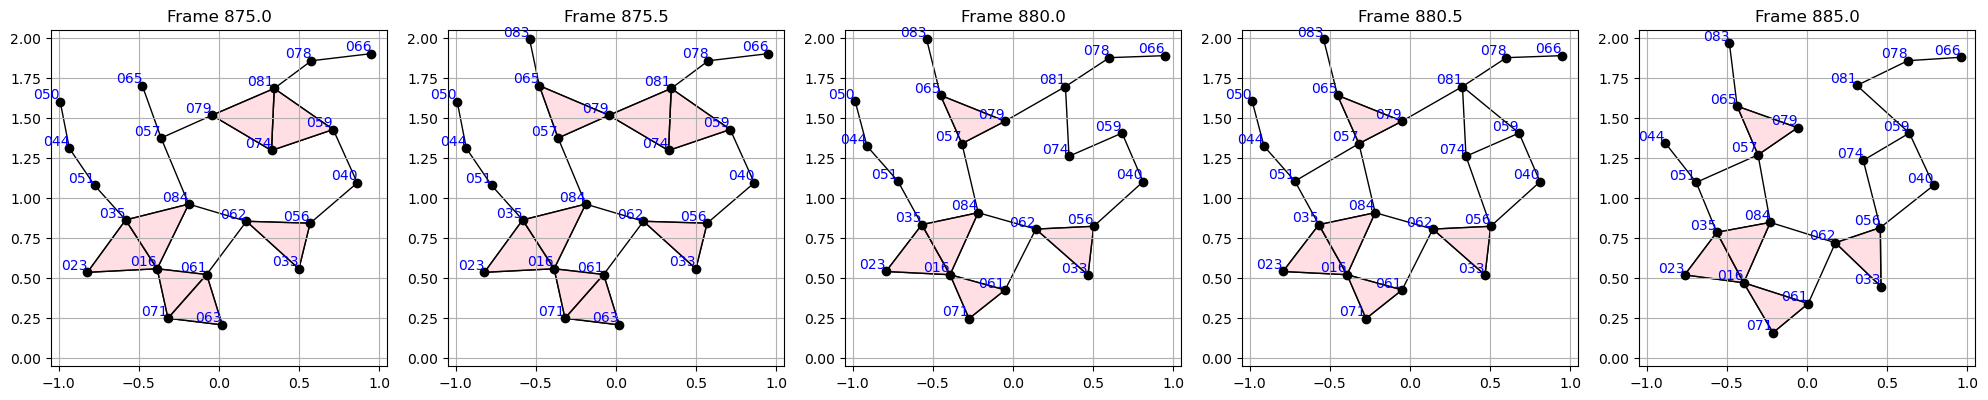

In [16]:
### visualizamos los simplices

fig, axes = plt.subplots(1, len(tabla_final.columns), figsize=(20, 5))  # Ancho x Alto
j = 0  # Índice para controlar posiciones

# Si solo hay un grafico, convertimos axes en una lista
if len(tabla_final.columns) == 1:
    axes = np.array([axes])

#dibujamos para cada tiempo
for i, ax in enumerate(axes):
    # Filtrar los elementos que son True en la columna actual
    elementos = tabla_final[tabla_final.iloc[:, i] == True]
    col = elementos.iloc[:, i]
    # Usar posiciones siguiente si es un tiempo intermedio
    if tabla_final.columns[i] not in t:
        k = j
        j -= 1
        pos = lista_dic_p[k-1] 
        
        for ind,coord in lista_dic_p[k].items():
            if ind not in lista_dic_p[k-1].keys():
                pos[ind] = coord
                
    else:
        pos = lista_dic_p[j]
    
    # Dibujar los  simpleses
    for simplice in col.index:
        if not (isinstance(simplice, (str, int)) and str(simplice) in map(str, individuos)):
            edge = list(simplice)
            #guardamos las coordenadas de cada punto de cada simplice
            vertices = [pos[edge[k]] for k in range(len(edge))]
            polygon = Polygon(vertices, closed=True, facecolor="pink", edgecolor=None, alpha=0.5)
            ax.add_patch(polygon)
            
            # Dibujar los bordes
            polygon_border = Polygon(vertices, closed=True, fill=None, edgecolor="black")
            ax.add_patch(polygon_border)
        else:
            # Dibujar los puntos 
            coord = np.array(pos[simplice])
            ax.scatter(coord[0], coord[1], color="black", zorder=3)
            # Dibujar las etiquetas
            ax.text(coord[0], coord[1], f"{simplice}", fontsize=10, ha="right", va="bottom", color="blue")
    
    # Configurar límites para cada subplot
    ax.set_title(f'Frame {tabla_final.columns[i]}')
    margen = 0.05
    ax.set_xlim(-dist_cuadrado/2 - margen, dist_cuadrado/2 + margen)  
    ax.set_ylim(0 - margen, dist_cuadrado + margen)
    ax.set_aspect('equal')  #sin distorsión del gráfico
    ax.grid(True)

    #pasamos a la siguiente posición
    j += 1

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Sacamos los intervalos de tiempos

In [17]:
simplices_tabla = list(tabla_final.index)
n = len(simplices_tabla)
#almacenamos los tiempos en una lista de listas
times = [[] for _ in range(n)]  # Una lista de n sublistas vacías

for  i,fila in enumerate(range(n)):
    #trabajamos con cada fila de la tabla
    lista_tabla = np.array(tabla_final.iloc[fila,:])
    cont = 0
    aux = True
    res = np.array([])
    
    #buscamos el primer True y nos quedamos con la fila a partir de ese indice
    while aux or cont == len(lista_tabla):
        if lista_tabla[cont]:
            res = np.append(res,tabla_final.columns[cont])
            #res = np.append(res,cont)   #si queremos tratar con indices

            aux = False
            lista = np.array(lista_tabla[cont:]) 
            
        else:
            cont += 1

    # encontramos los cambios de estado y nos quedamos con sus indices correspondientes
    if aux:
        print('no hay simplices')
    else:
        cambios = lista[:-1]!=lista[1:]
        ind_cambios = np.where(cambios)[0] + 1 + cont   #le sumamos el indice cont para que coincida con los indices de la tabla original
        res = np.append(res, tabla_final.columns[ind_cambios])
        #res = np.append(res, ind_cambios)        #si queremos tratar con indices
        
    #añadimos los tiempos de cada fila
    times[i] = res
print(times)


[array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875., 885.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875., 880.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.5]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875., 885.]), array([875.]), array([880.5]), array([875.]), array([880.5]), array([875.]), array([875.]), array([875.]), array([875.]), array([875. , 880. , 880.5]), array([875.]), array([875., 880.]), array([875.]), array([875.]), array([875., 880.]), array([875.5]), array([875.5]), array([875.]), array([875., 880.]), array([875., 885.]), array([875.]), array([875., 885.]), array([875.]), array([875.]), array([875.]), array([875.]), array([875.5]), 

# Persistencia Zig Zag

In [18]:
simplices_tabla = list(tabla_final.index)

#transformamos los simplices d dim1 en lista
st_transf = [[x] if not isinstance(x, list) else x for x in simplices_tabla]

#pasamos a numericos
stt_num = [[int(x) for x in simplex] for simplex in st_transf]

### Aplicamos la filtración y obtenemos los resultados de la homologia persistente

In [19]:
f = d.Filtration(stt_num)
zz, dgms, cells = d.zigzag_homology_persistence(f,times)  

In [20]:
#diagramas de persistencias dividido en dimensiones
for i,dgm in enumerate(dgms):
    print("Dimension:", i)
    for p in dgm:
        print(p)

Dimension: 0
(875,inf)
Dimension: 1
(875,885)
(880.5,885)
(880.5,inf)
(880.5,inf)
(875,inf)


### Guardar los intervalos de persistencia en un archivo csv